In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from helper_functions.grape_functions import *
from main_grape.Grape_original import Grape
from helper_functions.qutip_open_verification import *

%pylab inline

print parentdir
from IPython import display


Populating the interactive namespace from numpy and matplotlib
/home/mohamed/OQOC/OQOC_Github


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Defining time scales
total_time = 10.0
steps = 400

state_transfer = True
#Defining H0
qubit_state_num = 4
alpha = 0.224574
freq_ge = 3.9225#GHz
ens = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)- np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(np.arange(0,qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)
H0 = H_q 
       

#Defining Forbidden sates


#Defining Concerned states (starting states)
psi0=[1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2]
states_draw_names = ['g','e','f']

#Defining U (Target)
if state_transfer:
    U =[]
    U1 = np.zeros(qubit_state_num,dtype=complex)
    U1[1]=1
    U1[0]=0
    U.append(U1)
    U2 = np.zeros(qubit_state_num,dtype=complex)
    U2[0]=1
    #U.append(U2)
    
else:
    Ut_c = la.expm((0-1j)*total_time*H0)
    Ct_c = Ut_c.copy()
    Ct_c[1,0] = 1
    Ct_c[0,1] = 1
    Ct_c[0,0] = 0
    Ct_c[1,1] = 0
    U = Ct_c

print np.shape(U)
#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
U0= q_identity

#Defining control Hs
XI = Q_x
ZI = Q_z
Hops = [XI,ZI]
ops_max_amp = [3.0,3.0]
Hnames =['x','z']

#Defining convergence parameters
max_iterations = 5000
decay = max_iterations/2
convergence = {'rate':0, 'update_step':10, 'max_iterations':max_iterations,\
               'conv_target':2.5e-8,'learning_rate_decay':decay}
reg_coeffs = {'envelope' :0,  'dwdt':0.001,'d2wdt2':0.001*0.0001, 'forbidden':100 , 'states_forbidden_list': [3]}
#reg_coeffs = { 'speed_up':100}
#reg_coeffs = {'envelope' : 0,  'dwdt':0,'d2wdt2':0, 'forbidden':0 , 'states_forbidden_list': [3]}
#multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              #'f':freq_ge, 'es':w_c, 'g1':qm_g1, 'D':D, 'Interpolation':True, 'Modulation':True}

    #Defining initial pulses

print len(U)
print np.shape(Hops)

(1, 4)
1
(2, 4, 4)


In [6]:
#g = [1,0,0,0]
e = [0,1,0,0]
f = [0,0,1,0]
#ge = np.identity(4) + np.outer(g,e) - np.outer(e,e)
ef = np.identity(4) + np.outer(f,e) - np.outer(e,e)
T1_ge = 10.0
T1_ef = 30000.0
#ge=ge*np.sqrt(1/T1_ge) #decay from excited to ground qubit states
ef=ef*np.sqrt(1/T1_ef) #jump from excited to second excited state (f)
c_ops=[]
sm = 0.5* (Q_x + (0-1j)* Q_y) *np.sqrt(1/T1_ge)
c_ops.append(sm)
#c_ops.append(ef)

print c_ops
print np.shape(c_ops)

[array([[ 0.00000000+0.j,  0.79266546+0.j,  0.00000000+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j,  1.12099824+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  1.37293685+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j]])]
(1, 4, 4)


In [7]:
import h5py

with h5py.File('/home/mohamed/Data/01136_Qubit_Pi_open.h5','r') as hf:
    error = np.array(hf.get('error'))
    idx = list(error).index(np.min(error))
        
       
    u0 = np.array(hf.get('uks'))[idx]

u0 = None

#u0 = []
#u0.append(0*np.ones(steps))
#u0.append(0*np.ones(steps))

#u0 = None

TypeError: 'NoneType' object is not iterable

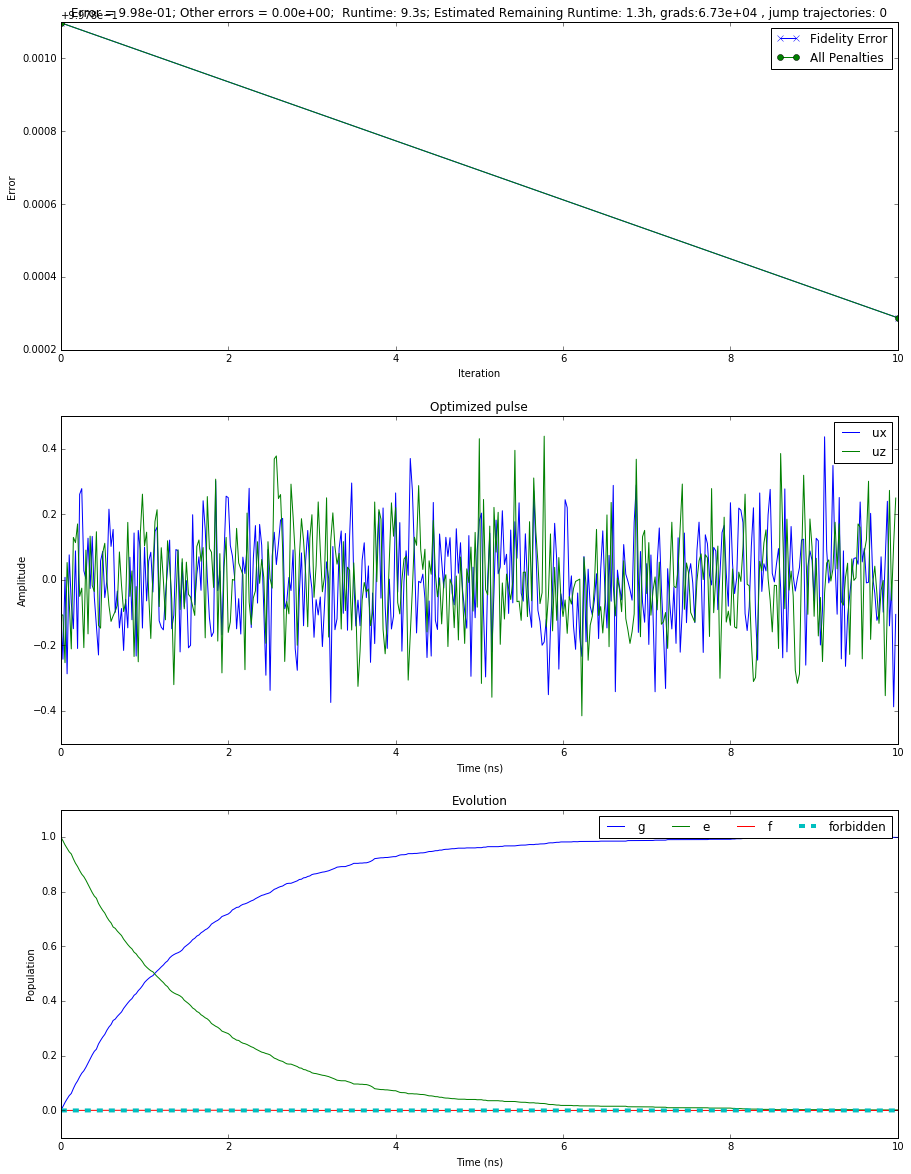

In [8]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True

      
uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],  
                    
                    show_plots = True, c_ops = c_ops, initial_guess = u0, use_gpu = False,
       unitary_error = 1e-4,  maxA=ops_max_amp, state_transfer = state_transfer, method ='Adam',
                    reg_coeffs=reg_coeffs, file_name='Qubit_Pi_open', trajectories = 1000, do_all_traj = True,
                    data_path = '/home/mohamed/Data')

In [ ]:
#1053 9% 1054 no c 1055 13.3%
#1060 no c 
#1079 no c 1082 3.3% 100ns 

In [ ]:
open_qutip_verification('/home/mohamed/Data/01143_Qubit_Pi_open.h5')



In [ ]:
open_qutip_verification('/home/mohamed/Data/01060_Qubit_Pi_open.h5')
open_qutip_verification('/home/mohamed/Data/01061_Qubit_Pi_open.h5')
open_qutip_verification('/home/mohamed/Data/01062_Qubit_Pi_open.h5')


In [ ]:
open_qutip_verification('/home/mohamed/Data/01079_Qubit_Pi_open.h5')
open_qutip_verification('/home/mohamed/Data/01082_Qubit_Pi_open.h5')
open_qutip_verification('/home/mohamed/Data/01084_Qubit_Pi_open.h5')

open_qutip_verification('/home/mohamed/Data/01085_Qubit_Pi_open.h5')
